### Modeling load

In [1]:
from mysql.connector import MySQLConnection, Error
import pandas as pd
from sqlalchemy import create_engine 
import pymysql
import datetime
import pytz
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error

from connection_config import read_db_config

In [2]:
conn_string,ssl_args = read_db_config('teama.teama')
engine = create_engine(conn_string,connect_args=ssl_args)

## Loading total load tables
Tables with raw data:
- totalload_2006_2015_entsoe_raw
- totalload_2015_entsoe_raw
- totalload_2016_entsoe_raw
- totalload_2017_entsoe_raw
- totalload_2018_entsoe_raw
- totalload_2019_entsoe_raw
- totalload_2020_entsoe_raw

In [3]:
# Load data
total_load_2020= pd.read_sql('SELECT * FROM totalload_2020_entsoe_raw', con=engine)
total_load_2019= pd.read_sql('SELECT * FROM totalload_2019_entsoe_raw', con=engine)
total_load_2018= pd.read_sql('SELECT * FROM totalload_2018_entsoe_raw', con=engine)
total_load_2017= pd.read_sql('SELECT * FROM totalload_2017_entsoe_raw', con=engine)
total_load_2016= pd.read_sql('SELECT * FROM totalload_2016_entsoe_raw', con=engine)
total_load_2015= pd.read_sql('SELECT * FROM totalload_2015_entsoe_raw', con=engine)

In [4]:
# I'll use three dataframes: 2015-2018 to train first, test on 2019, 
# and then use 2015-2019 to train again and use as 2020 prediction
total_load_2015_2018 = pd.concat([total_load_2015, total_load_2016, total_load_2017, total_load_2018], axis=0)

In [5]:
# Cleaning unknown 2020 data
total_load_2020 = total_load_2020[total_load_2020['Actual Total Load [MW] - BZN|GB'] != '-']

In [6]:
# Covnerting to UTC time 
def convert_to_UTC(datestring):
    split_text = datestring.split(sep = '-')
    first_half = split_text[0].strip()
    first_half_UTC = first_half+'+0000'
    date_UTC = datetime.datetime.strptime(first_half_UTC, "%d.%m.%Y %H:%M%z")
    london_tz = pytz.timezone('Europe/London')
    date_UK_time = date_UTC.astimezone(london_tz)
    
    return date_UK_time

total_load_2015_2018['Date UK time'] = total_load_2015_2018['Time (UTC)'].map(convert_to_UTC)
total_load_2019['Date UK time'] = total_load_2019['Time (UTC)'].map(convert_to_UTC)
total_load_2020['Date UK time'] = total_load_2020['Time (UTC)'].map(convert_to_UTC)

In [7]:
# Just some index changes and resampling steps 
total_load_2015_2018.set_index('Date UK time',inplace=True)
total_load_2019.set_index('Date UK time',inplace=True)
total_load_2020.set_index('Date UK time',inplace=True)

total_load_2015_2018['Actual Total Load [MW] - BZN|GB'] = pd.to_numeric(total_load_2015_2018['Actual Total Load [MW] - BZN|GB'])
total_load_2019['Actual Total Load [MW] - BZN|GB'] = pd.to_numeric(total_load_2019['Actual Total Load [MW] - BZN|GB'])
total_load_2020['Actual Total Load [MW] - BZN|GB'] = pd.to_numeric(total_load_2020['Actual Total Load [MW] - BZN|GB'])

date_load_2015_2018 = total_load_2015_2018[['Actual Total Load [MW] - BZN|GB']]
date_load_2019 = total_load_2019[['Actual Total Load [MW] - BZN|GB']]
date_load_20120 = total_load_2020[['Actual Total Load [MW] - BZN|GB']]

date_load_daily_2015_2018 = date_load_2015_2018.resample('D').mean()
date_load_daily_2019 = date_load_2019.resample('D').mean()
date_load_daily_2020 = date_load_20120.resample('D').mean()

date_load_daily_2015_2018.reset_index(level = 0, inplace = True)
date_load_daily_2019.reset_index(level = 0, inplace = True)
date_load_daily_2020.reset_index(level = 0, inplace = True)

date_load_daily_2015_2018['Date UK time'] = date_load_daily_2015_2018['Date UK time'].dt.date
date_load_daily_2019['Date UK time'] = date_load_daily_2019['Date UK time'].dt.date
date_load_daily_2020['Date UK time'] = date_load_daily_2020['Date UK time'].dt.date

In [8]:
# Rename to math prophet requirements
date_load_daily_2015_2018=date_load_daily_2015_2018.rename(columns={'Date UK time':'ds','Actual Total Load [MW] - BZN|GB':'y'})
date_load_daily_2019=date_load_daily_2019.rename(columns={'Date UK time':'ds','Actual Total Load [MW] - BZN|GB':'y'})
date_load_daily_2020=date_load_daily_2020.rename(columns={'Date UK time':'ds','Actual Total Load [MW] - BZN|GB':'y'})

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


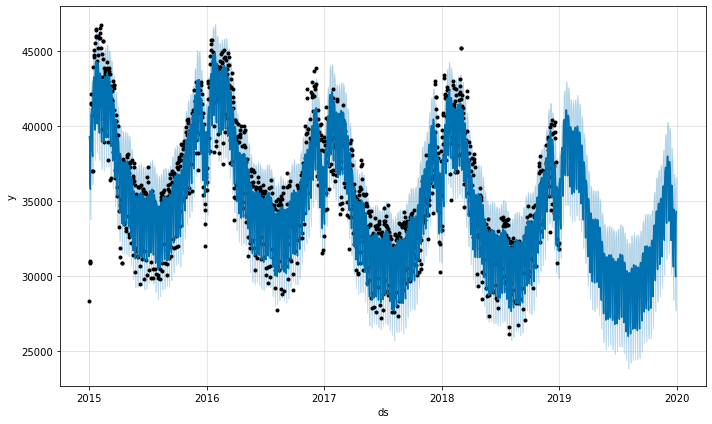

In [9]:
# Run prophet on 2015-2018, predict 2019
m = Prophet()
m.fit(date_load_daily_2015_2018)

future = m.make_future_dataframe(periods=365, freq='D')
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [12]:
# calculate MAE between expected and predicted values for december
forecast_2019 = forecast[-365:]

test_predict = forecast_2019['yhat'].values
mae = mean_absolute_error(date_load_daily_2019['y'], test_predict)
print('MAE: %.3f' % mae)

MAE: 1652.720


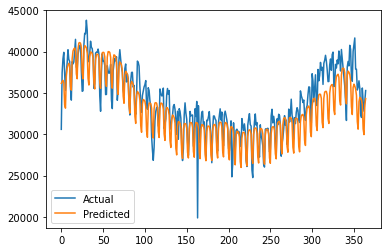

In [13]:
# Predicted 2019 vs actual 2019
from matplotlib import pyplot
# plot expected vs actual
pyplot.plot(date_load_daily_2019['y'], label='Actual')
pyplot.plot(test_predict, label='Predicted')
pyplot.legend()
pyplot.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


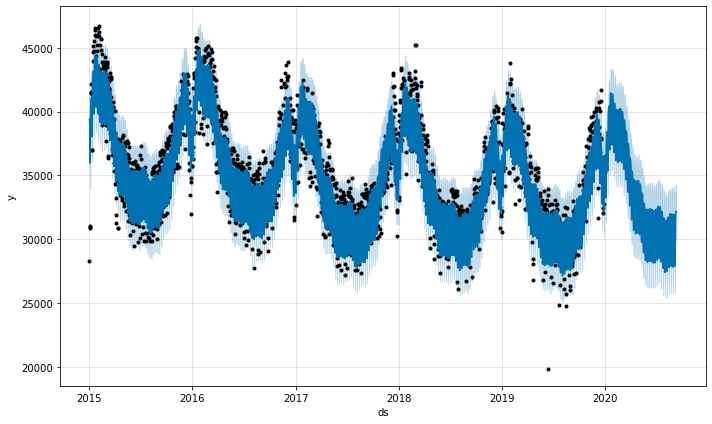

In [14]:
# Train model on 2015 - 2019 to predict 2020
date_load_daily_2015_2019 = pd.concat([date_load_daily_2015_2018,date_load_daily_2019], axis=0)

m = Prophet()
m.fit(date_load_daily_2015_2019)
future = m.make_future_dataframe(periods=date_load_daily_2020.shape[0], freq='D')
forecast = m.predict(future)
fig1 = m.plot(forecast)


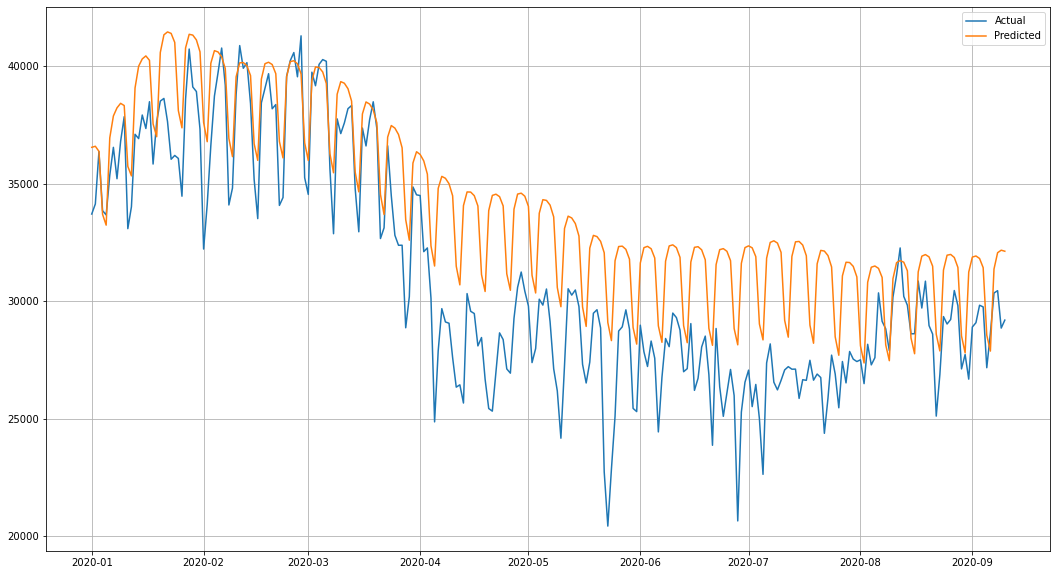

In [15]:
# Compare to truth 

forecast_2020 = forecast[-date_load_daily_2020.shape[0]:]
test_predict = forecast_2020['yhat'].values
test_predict_time = forecast_2020['ds'].values


fig= pyplot.figure(figsize=(18,10))
pyplot.plot(date_load_daily_2020['ds'],date_load_daily_2020['y'], label='Actual')
pyplot.plot(test_predict_time,test_predict, label='Predicted')
pyplot.legend()
pyplot.grid()
pyplot.show()

### Uploading data to database:
1. Database naming rules: once you clean data, keep the same name and change to raw to clean.
2. Use next cell to upload data onto database
3. If you're not done with cleaning, name it something like intermediate

### Once you upload the data, you can't rewrite it. Running the write command again (trying to create a new table with the same name) will cause error

In [ ]:
#clean_data_dataframe.to_sql('name_of_new_SQL_table',con = engine,if_exists = 'fail')